Installing the modules

In [1]:
!pip install openai python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


Importing the needed modules and setting up the OpenAI API

In [3]:
import pandas as pd
import os, re
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv(dotenv_path='apikey.env.txt')

APIKEY = os.getenv("APIKEY")
ORGID = os.getenv("ORGID")

client = OpenAI(api_key=APIKEY, organization=ORGID)

Loading our dataset

In [4]:
product_sales_data = pd.read_csv("product_sales_dataset.csv")
product_sales_data.head()

,Date,Product_Category,Product_Name,Product_Cost,Product_Price,Items_Sold
0,2018-01-01,Art & Crafts,Barrel O' Slime,1.99,3.99,281
1,2018-01-01,Art & Crafts,Etch A Sketch,10.99,20.99,42
2,2018-01-01,Art & Crafts,Kids Makeup Kit,13.99,19.99,39
3,2018-01-01,Art & Crafts,Magic Sand,13.99,15.99,128
4,2018-01-01,Art & Crafts,PlayDoh Can,1.99,2.99,145


Lets calculate profit per product

In [5]:
def calculate_product_profit(df, price_col, cost_col, items_sold_col):
    df['Product_Profit'] = (df[price_col] - df[cost_col]) * df[items_sold_col]
    return df.reset_index()

product_sales_data = calculate_product_profit(product_sales_data, 'Product_Price', 'Product_Cost','Items_Sold')
product_sales_data.head()

,index,Date,Product_Category,Product_Name,Product_Cost,Product_Price,Items_Sold,Product_Profit
0,0,2018-01-01,Art & Crafts,Barrel O' Slime,1.99,3.99,281,562.0
1,1,2018-01-01,Art & Crafts,Etch A Sketch,10.99,20.99,42,420.0
2,2,2018-01-01,Art & Crafts,Kids Makeup Kit,13.99,19.99,39,234.0
3,3,2018-01-01,Art & Crafts,Magic Sand,13.99,15.99,128,256.0
4,4,2018-01-01,Art & Crafts,PlayDoh Can,1.99,2.99,145,145.0


Defining some methods

In [44]:
def generate_chat_response(system_message, user_message):
    """
    Generates a response based on system and user messages using OpenAI's ChatCompletion API.

    Args:
        system_message (str): System's message.
        user_message (str): User's message.

    Returns:
        str: Generated response.
    """
    system = {'role': 'system', 'content': system_message}  # Define system's message structure
    user = {'role': 'user', 'content': user_message}  # Define user's message structure

    response = client.chat.completions.create(  # Call OpenAI's ChatCompletion API
        model='gpt-4',
        messages=[system, user],
        max_tokens=1200
    )

    return response.choices[0].message.content  # Return the generated response

def extract_code(response_content):
    """
    Extracts code from the response content.

    Args:
        response_content (str): Content of the response.

    Returns:
        str: Extracted code.
    """
    pattern = r'```(.*?)```'  # Define regex pattern to match code enclosed in ```
    matches = re.findall(pattern, response_content, re.DOTALL)  # Find all matches of the pattern
    return matches[0].replace("python", "")  # Return the extracted code

def create_chart(user_message, execute=True):
    """
    Generates Python code based on user message and optionally executes it.

    Args:
        user_message (str): User's message.
        execute (bool): Whether to execute the generated code.

    Returns:
        str: Generated Python code.
    """
    system_message = """
    You are a Python code generator familiar with pandas. Respond to every question with Python code.
    Wrap your code in ``` delimiters. Import any necessary Python modules. Do not provide elaborations.
    """

    response_content = generate_chat_response(system_message, user_message)  # Generate response
    code = extract_code(response_content)  # Extract code from response

    if execute:
        exec(code, globals())  # Execute the code if execute flag is True

    return code  # Return the generated code

def update_chart(code, user_message, execute=True):
    """
    Updates existing Python code based on user message and optionally executes it.

    Args:
        code (str): Existing Python code.
        user_message (str): User's message.
        execute (bool): Whether to execute the updated code.

    Returns:
        str: Updated Python code.
    """
    system_message = f"""
    You are a Python code updater familiar with pandas. You've been given the following Python method: {code}.
    Update the code based on the user content, but do not change the method name.
    Return the updated Python code wrapped in ``` delimiters. Do not provide elaborations.
    """

    response_content = generate_chat_response(system_message, user_message)  # Generate response
    current_chart = extract_code(response_content)  # Extract updated code from response

    if execute:
        exec(current_chart, globals())  # Execute the updated code if execute flag is True

    return current_chart  # Return the updated code


Generating a method for a line chart that shows average monthly Items_Sold over time.

Generated code for the current chart:  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def generated_method(df):
    df_copy = df.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    df_copy.set_index('Date', inplace=True)
    monthly_avg_profit = df_copy['Product_Profit'].resample('M').mean()

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=monthly_avg_profit)
    plt.title('Average Monthly Product Profit Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Monthly Profit')
    plt.show()



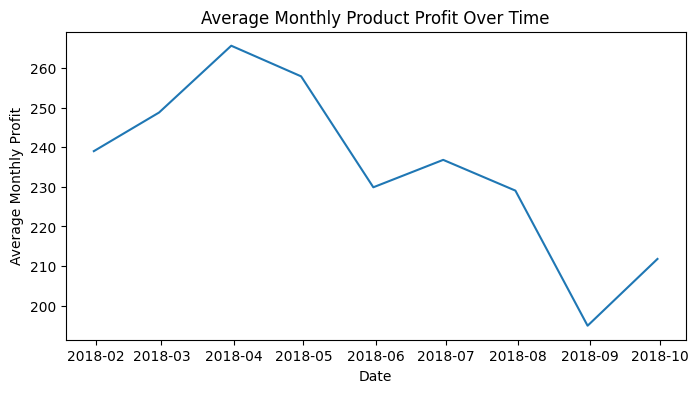

In [81]:
user_content = """
Return a python method called generated_method
that gets a datafarame first make a copy of the input dataframe and use the 'Date' column to aggergate the dataframe based on each month and calculate the average monthly 'Product_Profit'.
Then draws a line chart to visualize how the average monthly profit changes over time.
Use seaborn module.
Make the figsize (8, 4)
chart should have intuitive title and axis lables.
"""

current_chart = create_chart(user_content)

print("Generated code for the current chart: ", current_chart)

# Make use of the generated method
generated_method(product_sales_data)

<string>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



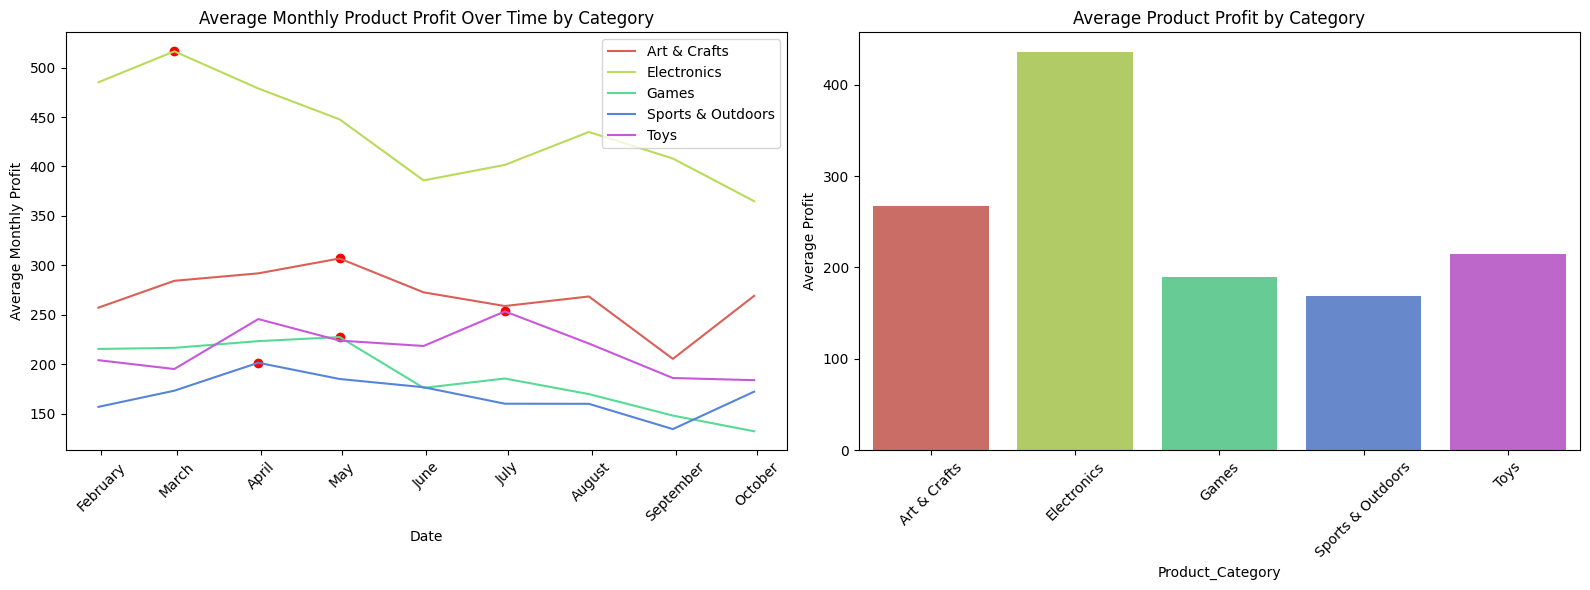

In [93]:
update_prompt = "Keep the chart height but reduce the width by 4"
current_chart = update_chart(current_chart,update_prompt)